# Visualise How FSPS Params Change SED

This notebook is much like gridding_foward_model/grid_verification.ipynb, in that it looks at how the photometry changes with each parameter, but is a test one step earlier. It's directly checking what FSPS says about the SED.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# you can do this, but it'll grind to a halt once you start making plots due to matplotlib really enjoying DEBUG statements...
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [3]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from prospect.utils.obsutils import fix_obs

from agnfinder.prospector import visualise, main, cpz_builders

In [4]:
os.chdir('/home/mike/repos/agnfinder')

In [5]:
!pwd

/home/mike/repos/agnfinder


In [6]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3.parquet'
galaxy_index = 10
galaxy = main.load_galaxy(catalog_loc, galaxy_index)
# redshift = galaxy['redshift']
# redshift = 0.001  # for now, to avoid rest/observer frame shifts (can't be exactly 0 or will evaluate False)
redshift = True

In [7]:
agn_mass = True
agn_eb_v = True
agn_torus_mass = True
igm_absorbtion = True

In [8]:
run_params, obs, model, sps = main.construct_problem(redshift=redshift, agn_mass=agn_mass, agn_eb_v=agn_eb_v, agn_torus_mass=agn_torus_mass, igm_absorbtion=igm_absorbtion, emulate_ssp=False)

sps should be an instance of my custom CSPSpecBasisAGN class

In [9]:
sps

In [10]:
model

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  agn_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  agn_eb_v: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)
  agn_torus_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  logzsol: 0.0 
  sfh: 4 
  imf_type: 2 
  dust_type: 2 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  add_igm_absorption: True 
  igm_factor: 1.0 

And model should include agn_mass and agn_eb_v

In [11]:
model.free_params

['zred',
 'mass',
 'dust2',
 'tage',
 'tau',
 'agn_mass',
 'agn_eb_v',
 'agn_torus_mass']

In [12]:
model.fixed_params

['logzsol',
 'sfh',
 'imf_type',
 'dust_type',
 'add_dust_emission',
 'duste_umin',
 'duste_qpah',
 'duste_gamma',
 'add_igm_absorption',
 'igm_factor']

In [13]:
model.initial_theta

array([1.e-01, 1.e+10, 6.e-01, 1.e+00, 1.e+00, 1.e+00, 1.e-01, 1.e-01])

In [14]:
model.theta

array([1.e-01, 1.e+10, 6.e-01, 1.e+00, 1.e+00, 1.e+00, 1.e-01, 1.e-01])

In [107]:
model_spectrum, model_photometry, _ = model.sed(model.initial_theta, obs, sps)  # trigger fsps calculation, takes a couple of minutes - then cached

In [108]:
model_photometry

array([0.07881951, 0.06948858, 0.07517713, 0.06412784, 0.05894721,
       0.02079655, 0.01987891, 0.03118782, 0.04301103, 0.06025804,
       0.0432361 , 0.03712749])

In [109]:
sps.quasar_flux

array([2.85818772e-17, 3.00416748e-17, 3.10465297e-17, ...,
       5.65752351e-28, 5.65752351e-28, 5.65752351e-28])

In [110]:
assert max(sps.quasar_flux) > min(sps.quasar_flux)  # quasar component should be SOMETHING

In [111]:
model_param_index = dict(zip(model.free_params, range(len(model.free_params))))

In [112]:
def set_galaxy_param(galaxy, param, value):
    new_galaxy = galaxy.copy()
    new_galaxy[model_param_index[param]] = value
    return new_galaxy

In [113]:
def visualise_models(models, varying_param, ylim=[10**-18, None]):
    fig, ax = plt.subplots(figsize=(16, 8))
    for galaxy in galaxies:
        visualise.plot_model_at_obs(ax, model, galaxy, obs, sps, spectra_label='{}={:.3e}'.format(varying_param, galaxy[model_param_index[varying_param]]), photo_label=None)
        ax.legend()
    ax.set_ylim(ylim)
    # plt.loglog(sps.wavelengths, sps.galaxy_flux, label='Galaxy')

## How does the SED change as we vary the galaxy (non-AGN) parameters?

In [114]:
# ['mass', 'dust2', 'tage', 'tau',
theta_no_agn = model.initial_theta
theta_no_agn = set_galaxy_param(theta_no_agn, 'agn_torus_mass', 0)
theta_no_agn = set_galaxy_param(theta_no_agn, 'agn_mass', 0)

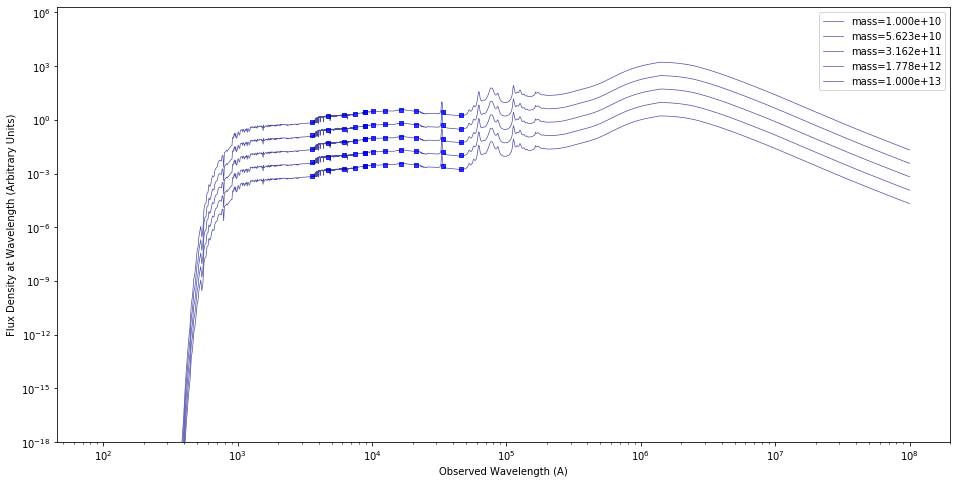

In [115]:
galaxies = [set_galaxy_param(theta_no_agn, 'mass', x) for x in np.logspace(10, 13, num=5)]
visualise_models(galaxies, varying_param='mass')

Mass is a straight-up scale, as expected

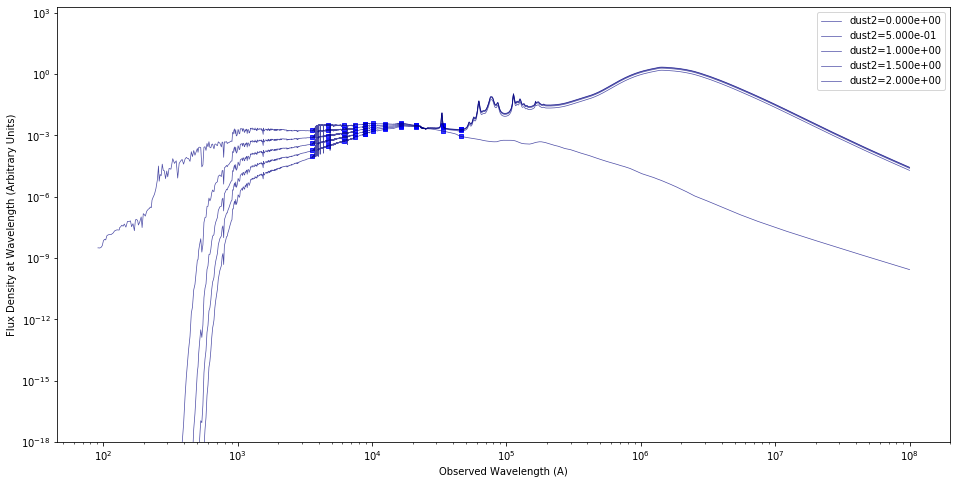

In [116]:
galaxies = [set_galaxy_param(theta_no_agn, 'dust2', x) for x in np.linspace(0, 2, num=5)]
visualise_models(galaxies, varying_param='dust2')

In [117]:
theta_no_agn[model_param_index['tage']]

1.0

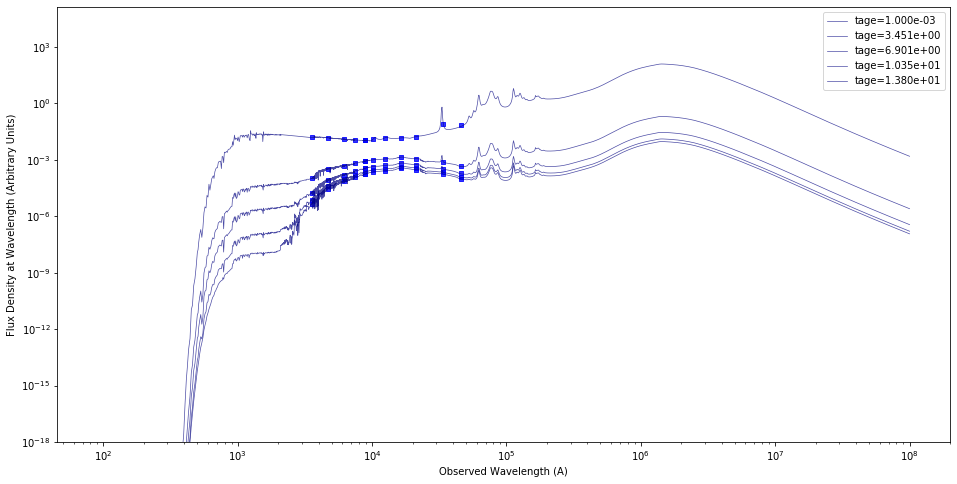

In [118]:
galaxies = [set_galaxy_param(theta_no_agn, 'tage', x) for x in np.linspace(0.001, 13.8, num=5)]
visualise_models(galaxies, varying_param='tage')

In [121]:
theta_no_agn[model_param_index['tage']]

1.0

In [153]:
np.log(.1)

-2.3025850929940455

In [152]:
np.log(2)

0.6931471805599453

In [154]:
np.logspace(np.log10(0.1), np.log10(2), num=15)

array([0.1       , 0.1238599 , 0.15341274, 0.19001686, 0.23535469,
       0.29151008, 0.36106408, 0.4472136 , 0.5539183 , 0.68608263,
       0.84978124, 1.05253817, 1.30367269, 1.61472765, 2.        ])

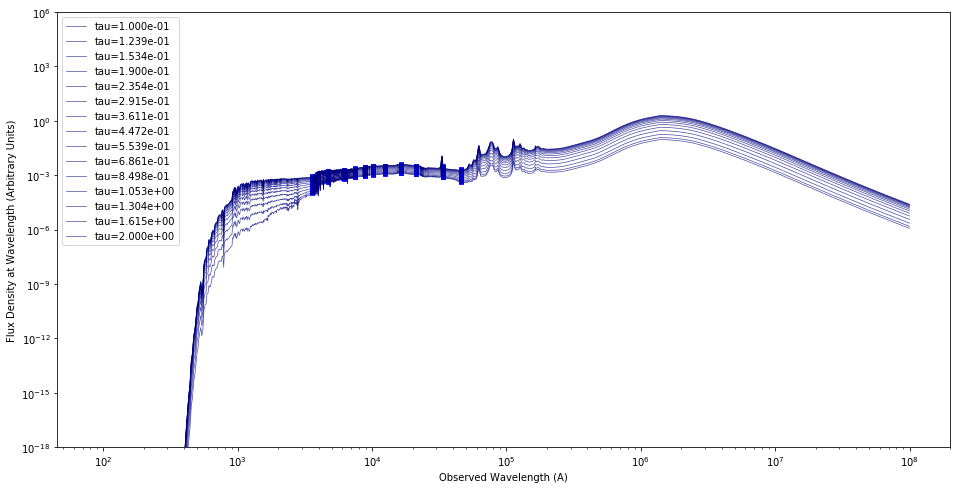

In [155]:
galaxies = [set_galaxy_param(theta_no_agn, 'tau', x) for x in np.logspace(np.log10(0.1), np.log10(2), num=15)]
visualise_models(galaxies, varying_param='tau', ylim=[10**-18, 10**6])

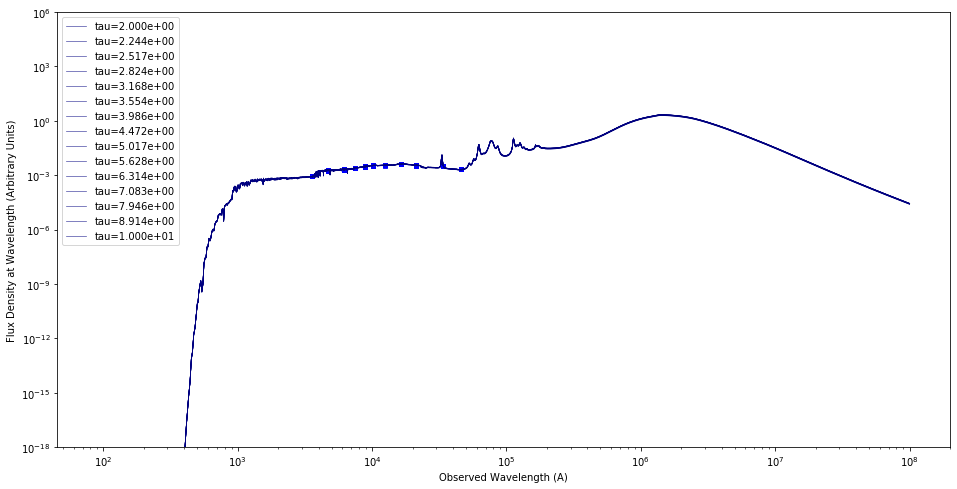

In [156]:
galaxies = [set_galaxy_param(theta_no_agn, 'tau', x) for x in np.logspace(np.log10(2), np.log10(10), num=15)]
visualise_models(galaxies, varying_param='tau', ylim=[10**-18, 10**6])

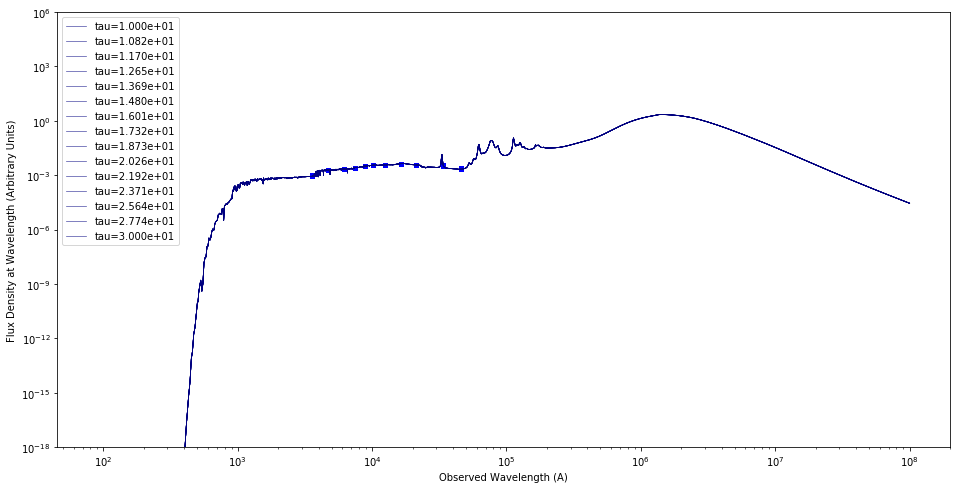

In [157]:
galaxies = [set_galaxy_param(theta_no_agn, 'tau', x) for x in np.logspace(np.log10(10), np.log10(30), num=15)]
visualise_models(galaxies, varying_param='tau', ylim=[10**-18, 10**6])

How do tau and tage jointly affect the SED?

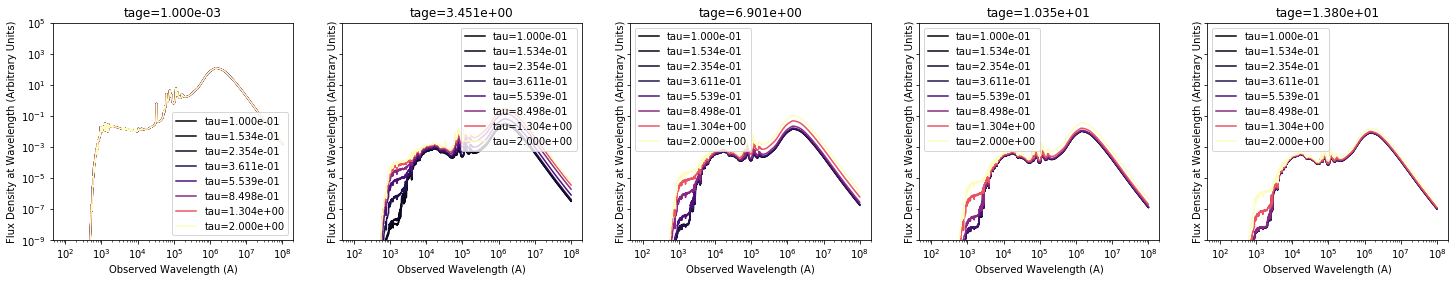

In [158]:

tages = np.linspace(0.001, 13.8, num=5)
taus = np.logspace(np.log10(0.1), np.log10(2), num=8)

fig, axes = plt.subplots(ncols=len(tages), figsize=(25, 4), sharex=True, sharey=True)
ylim=[10**-9, 10**5]
for col_n, tage in enumerate(tages):
    base_galaxy = set_galaxy_param(theta_no_agn, 'tage', tage)
    galaxies = [set_galaxy_param(base_galaxy, 'tau', x) for x in taus]
    ax = axes[col_n]
    varying_param = 'tau'
    for galaxy_n, galaxy in enumerate(galaxies):
        normalised_taus = 1. * (taus - taus.min()) / (taus.max() - taus.min())
        color = cm.magma(normalised_taus[galaxy_n])
        visualise.plot_model_at_obs(ax, model, galaxy, obs, sps, spectra_label='{}={:.3e}'.format(varying_param, galaxy[model_param_index[varying_param]]), spectra_kwargs={'color': color}, photo_kwargs={'alpha': .001}, photo_label=None)
    ax.legend()
    ax.set_title('tage={:.3e}'.format(tage))
    ax.set_ylim(ylim)

## How does the SED change as we vary the AGN parameters?

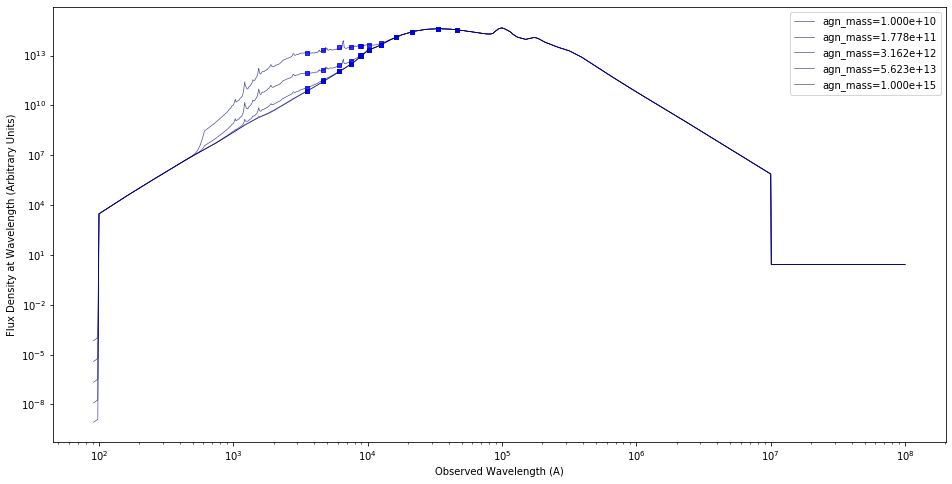

In [56]:
galaxies = [set_galaxy_param(model.theta, 'agn_mass', x) for x in np.logspace(10, 15, num=5)]
visualise_models(galaxies, varying_param='agn_mass')

In [47]:
observer_wavelengths = visualise.get_observer_frame_wavelengths(model, sps)

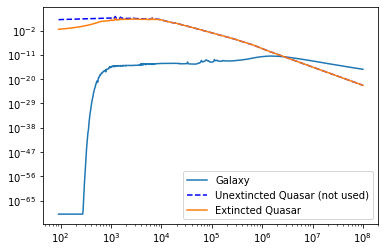

In [28]:
plt.loglog(observer_wavelengths, sps.galaxy_flux, label='Galaxy')
plt.loglog(observer_wavelengths, sps.unextincted_quasar_flux, 'b--', label='Unextincted Quasar (not used)')
plt.loglog(observer_wavelengths, sps.extincted_quasar_flux, label='Extincted Quasar')
# plt.loglog(observer_wavelengths, sps.torus_flux, label='Torus')
# plt.loglog(observer_wavelengths, sps.quasar_flux, 'k', label='Net (Quasar)')
plt.legend()

What if we add extinction?

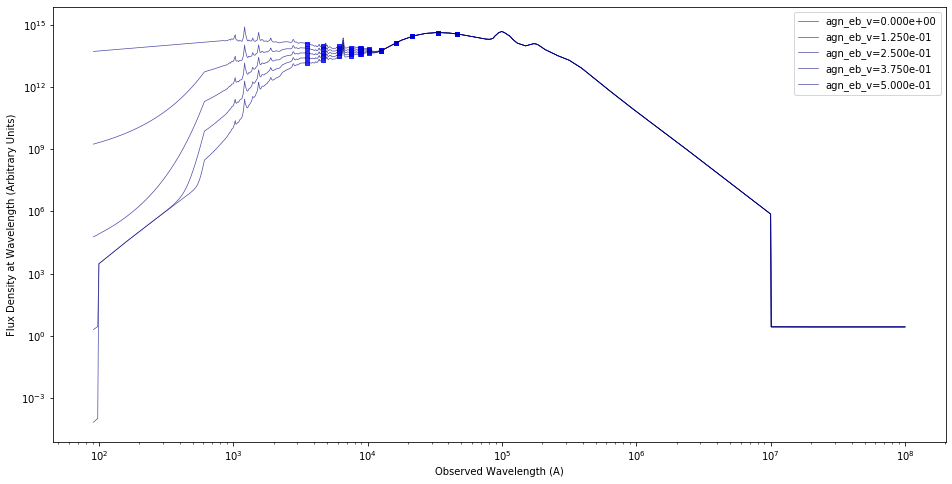

In [48]:
galaxies = [set_galaxy_param(model.theta, 'agn_eb_v', x) for x in np.linspace(0, .5, num=5)]
visualise_models(galaxies, varying_param='agn_eb_v')

What about the torus?

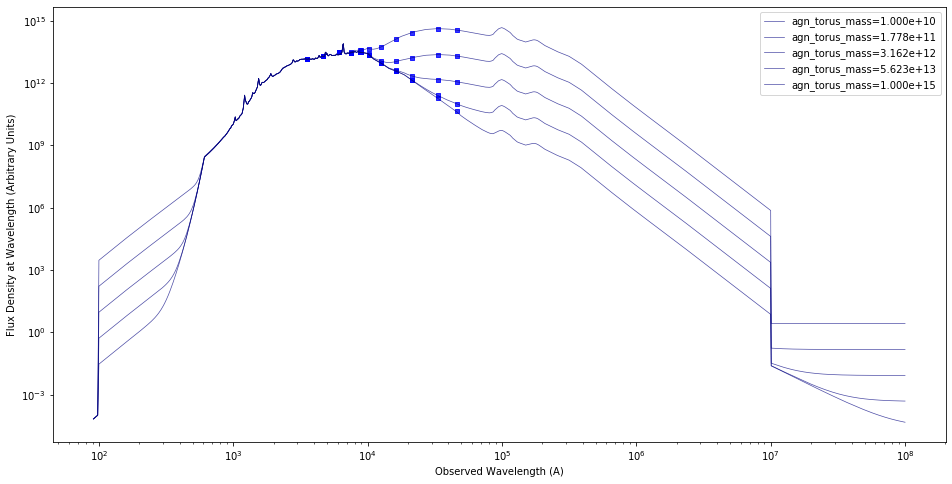

In [50]:
galaxies = [set_galaxy_param(model.theta, 'agn_torus_mass', x) for x in np.logspace(10, 15, num=5)]
visualise_models(galaxies, varying_param='agn_torus_mass')

And let's just check that extinction also applies to the torus

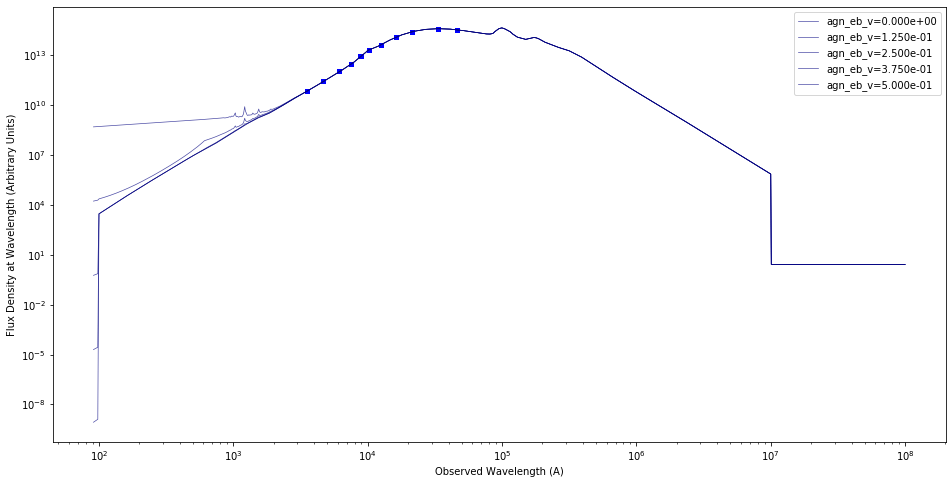

In [55]:
model_strong_torus = model.theta
model_strong_torus = set_galaxy_param(model_strong_torus, 'agn_torus_mass', 10 ** 15)
model_strong_torus = set_galaxy_param(model_strong_torus, 'agn_mass', 10 ** 10)
galaxies = [set_galaxy_param(model_strong_torus, 'agn_eb_v', x) for x in np.linspace(0, .5, num=5)]
visualise_models(galaxies, varying_param='agn_eb_v')

So AGN extinction doesn't have much effect on the torus, and will have a much bigger effect on AGN-disk-dominated galaxies - as expected

In [ ]:
plot_components(observer_wavelengths, sps)
plt.ylim([1e-30, 1e-13])
plt.xlim([1e3, 1e7])

In [ ]:
theta_agn[model_param_index['mass']]

## What does this look like for a model that we've actually fit?

Latest results: loguniform priors, 1e14 rescaling

In [ ]:
def load_theta_from_samples(samples_loc):
    with h5py.File(samples_loc, 'r') as f:
        samples = f['samples'][...]
        return np.median(samples, axis=0)

In [ ]:
# old: AGN now 1e14 bigger

### Quasar?

In [ ]:
samples_loc = '/home/mike/repos/agnfinder/results/mixed_wide_loguniform_priors_fixed_inclination/qso_loguniform_mass_0_1564681166_multinest_samples.h5py'
assert os.path.isfile(samples_loc)
fit_theta = load_theta_from_samples(samples_loc)
dict(zip(model.free_params, fit_theta))

In [ ]:
fit_theta

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
visualise.plot_model_at_obs(ax, model, fit_theta, obs, sps)  
ax.set_ylim([1e-20, 1e1])
ax.set_xlim([1e3, 1e7])

In [ ]:
plot_components(observer_wavelengths, sps)
plt.ylim([1e-17, 1e-10])
plt.xlim([1e3, 1e7])

Quasar and torus dominate all except the cold gas component, just as we'd like.

### Starforming?

In [ ]:
samples_loc = '/home/mike/repos/agnfinder/results/mixed_wide_loguniform_priors_fixed_inclination/starforming_loguniform_mass_0_1564679182_multinest_samples.h5py'
assert os.path.isfile(samples_loc)
fit_theta = load_theta_from_samples(samples_loc)
dict(zip(model.free_params, fit_theta))


fig, ax = plt.subplots(figsize=(16, 6))
visualise.plot_model_at_obs(ax, model, fit_theta, obs, sps)  
ax.set_ylim([1e-25, 1e-6])
ax.set_xlim([1e3, 1e7])


In [ ]:
components = visualise.get_components(sps)  # order matters! must be most recent sps calc....
visualise.plot_components(components)
plt.ylim([1e-20, 1e-14])
plt.xlim([1e3, 1e7])

The quasar still makes a noticeable contribution at the bluest wavelengths, where the galaxy flux is lowest. So I still need a prior that allows for an even lower quasar contribution, by 2 orders of magnitude or so.

GALEX FUV is at about 1500 angstroms, which would be in the agn-contribution zone - except for redshift, which (for this particular quasar) pushes FUV observations to the longer-wavelength galaxy-dominated regime - so we get away with it here.

### AGN?

In [ ]:
samples_loc = '/home/mike/repos/agnfinder/results/mixed_wide_loguniform_priors_fixed_inclination/agn_loguniform_mass_0_1564679232_multinest_samples.h5py'
assert os.path.isfile(samples_loc)
fit_theta = load_theta_from_samples(samples_loc)
dict(zip(model.free_params, fit_theta))

fig, ax = plt.subplots(figsize=(16, 6))
visualise.plot_model_at_obs(ax, model, fit_theta, obs, sps)  
# ax.set_ylim([1e-10, 1e-6])
# ax.set_xlim([1e3, 1e7])

In [ ]:
plot_components(observer_wavelengths, sps)
plt.ylim([1e-18, 1e-11])
plt.xlim([1e3, 1e7])

In [ ]:
samples_loc = '/home/mike/repos/agnfinder/results/mixed_wide_loguniform_priors_fixed_inclination/agn_loguniform_mass_0_1564679232_multinest_samples.h5py'
assert os.path.isfile(samples_loc)
fit_theta = load_theta_from_samples(samples_loc)
dict(zip(model.free_params, fit_theta))

fig, ax = plt.subplots(figsize=(16, 6))
visualise.plot_model_at_obs(ax, model, fit_theta, obs, sps)  
ax.set_ylim([1e-10, 1e-6])
ax.set_xlim([1e3, 17])

In [ ]:
plot_components(observer_wavelengths, sps)
plt.ylim([1e-18, 1e-11])
plt.xlim([1e3, 1e7])

Is it worrying that the torus extinction can be so small? I think it would be a good idea to decide on a link between these...